# NYC Taxi Data Preprocessing

This notebook preprocesses the NYC yellow taxi trip dataset for our AI course project. We load taxi trip data, merge with zone information, integrate real NOAA weather data, and engineer features for demand prediction and clustering.

**Contribution of Muneeb**: Data loading, cleaning, feature engineering, weather integration, and zone centroid extraction.

## Step 1: Import Libraries
We need libraries for data processing, geospatial operations, and feature engineering.

In [1]:
import pandas as pd
import dask.dataframe as dd
import glob
import numpy as np
from datetime import datetime
import holidays
import geopandas as gpd
import os
import json
import matplotlib.pyplot as plt

# Define base URL for file paths
base_url = "/Users/saleh/Desktop/Projects/AIProject/TaxiOptimization/"

# For tracking row counts
row_counts = []

## Step 2: Load Taxi Data
Load the yellow taxi trip Parquet files using Dask for scalability, then convert to Pandas for processing.

In [2]:
# Load taxi data with Dask
parquet_files = glob.glob(base_url + "data/raw/taxi_data/*.parquet")
if not parquet_files:
    raise FileNotFoundError(f"No Parquet files found at {base_url}data/raw/taxi_data/")
ddf = dd.read_parquet(parquet_files)
taxi_df = ddf.compute()  # Convert to Pandas
print(f"Loaded {len(taxi_df)} trip records from {len(parquet_files)} files.")
row_counts.append({"step": "Initial Load", "rows": len(taxi_df)})

Loaded 20332093 trip records from 6 files.


## Step 3: Load and Clean Zone Data
Load `taxi_zones.csv` and validate `LocationID`, `Borough`, and `Zone`. Merge with GeoJSON centroids for spatial features.

In [3]:
# Load zone information
zones_path = base_url + "data/raw/zones/taxi_zones.csv"
try:
    zones_df = pd.read_csv(zones_path)
    print(f"Loaded {len(zones_df)} zones.")
except FileNotFoundError:
    print(f"Error: taxi_zones.csv not found at {zones_path}")
    raise

# Clean zone data
initial_zones = len(zones_df)
zones_df = zones_df.dropna(subset=["LocationID", "Borough", "Zone"])
zones_df = zones_df[zones_df["LocationID"].isin(range(1, 266))]  # Valid LocationID: 1-265
print(f"Kept {len(zones_df)} zones after cleaning ({initial_zones - len(zones_df)} dropped).")

# Load GeoJSON for centroids
geojson_path = base_url + "data/raw/zones/taxi_zones.geojson"
print(f"Attempting to load GeoJSON from: {geojson_path}")

# Validate GeoJSON
try:
    with open(geojson_path, "r") as f:
        json.load(f)
    print("GeoJSON file is valid JSON.")
except json.JSONDecodeError as e:
    print(f"Error: Invalid GeoJSON file - JSON parsing failed: {str(e)}")
    raise
except FileNotFoundError:
    print(f"Error: GeoJSON file not found at {geojson_path}")
    raise

# Load GeoJSON
try:
    gdf = gpd.read_file(geojson_path)
    zones_df["lat"] = gdf.geometry.centroid.y
    zones_df["lon"] = gdf.geometry.centroid.x
    # Broader NYC bounds to include all zones (e.g., JFK, Staten Island)
    zones_df = zones_df[
        (zones_df["lat"].between(40.4, 41.1)) & (zones_df["lon"].between(-74.5, -73.5))
    ]
    print(f"Loaded GeoJSON with {len(zones_df)} valid centroids.")
except Exception as e:
    print(f"Error loading GeoJSON: {str(e)}")
    raise

# Merge zones with taxi data
taxi_df = taxi_df.merge(zones_df, left_on="PULocationID", right_on="LocationID", how="inner") \
                 .rename(columns={"Borough": "Pickup_Borough", "Zone": "Pickup_Zone", "lat": "pickup_lat", "lon": "pickup_lon"}) \
                 .drop(columns=["LocationID", "service_zone"])
taxi_df = taxi_df.merge(zones_df, left_on="DOLocationID", right_on="LocationID", how="inner") \
                 .rename(columns={"Borough": "Dropoff_Borough", "Zone": "Dropoff_Zone", "lat": "dropoff_lat", "lon": "dropoff_lon"}) \
                 .drop(columns=["LocationID", "service_zone"])
print(f"After zone merge: {len(taxi_df)} rows.")
row_counts.append({"step": "Zone Merge", "rows": len(taxi_df)})

Loaded 265 zones.
Kept 263 zones after cleaning (2 dropped).
Attempting to load GeoJSON from: /Users/saleh/Desktop/Projects/AIProject/TaxiOptimization/data/raw/zones/taxi_zones.geojson
GeoJSON file is valid JSON.


/var/folders/7y/m_z50_qs7rx24x9wgdn7n8h80000gn/T/ipykernel_47053/250717021.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_df["lat"] = gdf.geometry.centroid.y
/var/folders/7y/m_z50_qs7rx24x9wgdn7n8h80000gn/T/ipykernel_47053/250717021.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_df["lon"] = gdf.geometry.centroid.x


Loaded GeoJSON with 263 valid centroids.
After zone merge: 20123221 rows.


## Step 4: Clean Taxi Data
Clean the taxi dataset by validating timestamps, fares, and trip details. Track row counts to diagnose data loss.

In [4]:
# Convert timestamps
taxi_df["pickup_datetime"] = pd.to_datetime(taxi_df["tpep_pickup_datetime"], errors="coerce")
taxi_df["dropoff_datetime"] = pd.to_datetime(taxi_df["tpep_dropoff_datetime"], errors="coerce")
taxi_df = taxi_df.dropna(subset=["pickup_datetime", "dropoff_datetime"])
print(f"After timestamp conversion: {len(taxi_df)} rows.")
row_counts.append({"step": "Timestamp Conversion", "rows": len(taxi_df)})

# Dynamic date range
min_date = taxi_df["pickup_datetime"].min().floor("D")
max_date = taxi_df["pickup_datetime"].max().ceil("D")
print(f"Dataset date range: {min_date} to {max_date}")
taxi_df = taxi_df[
    (taxi_df["pickup_datetime"] >= min_date) &
    (taxi_df["pickup_datetime"] <= max_date) &
    (taxi_df["dropoff_datetime"] >= min_date) &
    (taxi_df["dropoff_datetime"] <= max_date) &
    (taxi_df["pickup_datetime"] <= taxi_df["dropoff_datetime"])
]
print(f"After date range filter: {len(taxi_df)} rows.")
row_counts.append({"step": "Date Range Filter", "rows": len(taxi_df)})

# Filter trip details
taxi_df = taxi_df[
    (taxi_df["trip_distance"] > 0) & (taxi_df["trip_distance"] < 100) &
    (taxi_df["total_amount"] > 0) & (taxi_df["total_amount"] < 500) &
    (taxi_df["passenger_count"] > 0) & (taxi_df["passenger_count"] < 10)
]
print(f"After trip filters: {len(taxi_df)} rows.")
row_counts.append({"step": "Trip Filters", "rows": len(taxi_df)})

# Validate fares and surcharges
fare_cols = ["fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge", "Airport_fee"]
for col in fare_cols:
    if col in taxi_df.columns:
        taxi_df = taxi_df[taxi_df[col] >= 0]
print(f"After fare validation: {len(taxi_df)} rows.")
row_counts.append({"step": "Fare Validation", "rows": len(taxi_df)})

# Validate RatecodeID
if "RatecodeID" in taxi_df.columns:
    taxi_df = taxi_df[taxi_df["RatecodeID"].isin([1, 2, 3, 4, 5, 6])]
print(f"After RatecodeID filter: {len(taxi_df)} rows.")
row_counts.append({"step": "RatecodeID Filter", "rows": len(taxi_df)})

# Remove duplicates
taxi_df = taxi_df.drop_duplicates(subset=["VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime"])
print(f"After duplicate removal: {len(taxi_df)} rows.")
row_counts.append({"step": "Duplicate Removal", "rows": len(taxi_df)})

After timestamp conversion: 20123221 rows.
Dataset date range: 2002-12-31 00:00:00 to 2026-06-27 00:00:00
After date range filter: 20123163 rows.
After trip filters: 17495231 rows.
After fare validation: 17495190 rows.
After RatecodeID filter: 17291573 rows.
After duplicate removal: 17286600 rows.


## Step 5: Feature Engineering
Engineer temporal, trip-based, and demand-based features for modeling.

In [5]:
# Temporal features
taxi_df["hour"] = taxi_df["pickup_datetime"].dt.hour
taxi_df["day_of_week"] = taxi_df["pickup_datetime"].dt.dayofweek
taxi_df["month"] = taxi_df["pickup_datetime"].dt.month
us_holidays = holidays.US()
taxi_df["is_holiday"] = taxi_df["pickup_datetime"].apply(lambda x: 1 if x in us_holidays else 0)

# Trip-based features
taxi_df["trip_duration"] = (taxi_df["dropoff_datetime"] - taxi_df["pickup_datetime"]).dt.total_seconds() / 60
taxi_df = taxi_df[taxi_df["trip_duration"] > 0]
taxi_df["avg_speed"] = taxi_df["trip_distance"] / (taxi_df["trip_duration"] / 60)
taxi_df = taxi_df[taxi_df["avg_speed"] < 100]
print(f"After trip feature filters: {len(taxi_df)} rows.")
row_counts.append({"step": "Trip Feature Filters", "rows": len(taxi_df)})

# Demand-based features
pickup_counts = taxi_df.groupby(["PULocationID", "hour"])["VendorID"].count().reset_index(name="pickup_count")
if "pickup_count" in taxi_df.columns:
    taxi_df = taxi_df.drop(columns=["pickup_count"])
taxi_df = taxi_df.merge(pickup_counts, on=["PULocationID", "hour"], how="left")
print(f"After demand features: {len(taxi_df)} rows.")
row_counts.append({"step": "Demand Features", "rows": len(taxi_df)})
print("Added demand-based features.")

After trip feature filters: 17282918 rows.
After demand features: 17282918 rows.
Added demand-based features.


## Step 6: Integrate NOAA Weather Data
Load and process NOAA ISD weather data (JFK station), merging with taxi data.

In [6]:
# Load NOAA weather data
weather_file = base_url + "data/external/jfk_hourly_weather_2024.csv"
if not os.path.exists(weather_file):
    print(f"Error: Weather data not found at {weather_file}")
    print("Download JFK 2023-2024 data from:")
    print("2023: https://www.ncei.noaa.gov/data/global-hourly/access/2023/947890.csv")
    raise FileNotFoundError
else:
    weather_data = pd.read_csv(weather_file)
    print("Available weather columns:", weather_data.columns.tolist())
    # Parse datetime
    weather_data["date"] = pd.to_datetime(weather_data["DATE"], errors="coerce")
    # Extract temperature (°C to °F)
    weather_data["temperature"] = weather_data["TMP"].str.split(",", expand=True)[0].replace(r"[^0-9\-+]", "", regex=True).astype(float) / 10 * 9/5 + 32
    # Extract precipitation (mm to inches)
    if "AA1" in weather_data.columns:
        weather_data["precipitation"] = weather_data["AA1"].str.split(",", expand=True)[0].replace(r"[^0-9]", "", regex=True).astype(float) / 25.4
    else:
        print("Warning: AA1 column not found, setting precipitation to 0.")
        weather_data["precipitation"] = 0
    # Extract wind speed (m/s to mph)
    weather_data["wind_speed"] = weather_data["WND"].str.split(",", expand=True)[3].replace(r"[^0-9]", "", regex=True).astype(float) / 10 * 2.23694
    # Select columns
    weather_data = weather_data[["date", "temperature", "precipitation", "wind_speed"]]
    weather_data = weather_data.dropna(subset=["date"])
    weather_data[["temperature", "precipitation", "wind_speed"]] = weather_data[["temperature", "precipitation", "wind_speed"]].fillna(method="ffill").fillna(0)
    print("Loaded and processed NOAA weather data.")

# Merge weather data
taxi_df["date"] = taxi_df["pickup_datetime"].dt.floor("h")
taxi_df = taxi_df.merge(weather_data, on="date", how="left")
taxi_df[["temperature", "precipitation", "wind_speed"]] = taxi_df[["temperature", "precipitation", "wind_speed"]].fillna(method="ffill").fillna(0)
print(f"After weather merge: {len(taxi_df)} rows.")
row_counts.append({"step": "Weather Merge", "rows": len(taxi_df)})
print("Integrated real weather data.")

/var/folders/7y/m_z50_qs7rx24x9wgdn7n8h80000gn/T/ipykernel_47053/3096562332.py:9: DtypeWarning: Columns (2,43,44,48,53,56,61,86) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(weather_file)


Available weather columns: ['STATION', 'DATE', 'SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'REPORT_TYPE', 'CALL_SIGN', 'QUALITY_CONTROL', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP', 'AA1', 'AA2', 'AA3', 'AB1', 'AD1', 'AE1', 'AH1', 'AH2', 'AH3', 'AH4', 'AH5', 'AH6', 'AI1', 'AI2', 'AI3', 'AI4', 'AI5', 'AI6', 'AJ1', 'AK1', 'AL1', 'AM1', 'AN1', 'AT1', 'AT2', 'AT3', 'AT4', 'AT5', 'AT6', 'AU1', 'AU2', 'AU3', 'AU4', 'AW1', 'AW2', 'AW3', 'AW4', 'AW5', 'AX1', 'AX2', 'AX3', 'ED1', 'GA1', 'GA2', 'GA3', 'GA4', 'GD1', 'GD2', 'GD3', 'GD4', 'GE1', 'GF1', 'KA1', 'KA2', 'KB1', 'KB2', 'KB3', 'KC1', 'KC2', 'KD1', 'KD2', 'KE1', 'KG1', 'KG2', 'MA1', 'MD1', 'MF1', 'MG1', 'MH1', 'MK1', 'MV1', 'MW1', 'MW2', 'MW3', 'OC1', 'OD1', 'OE1', 'OE2', 'OE3', 'RH1', 'RH2', 'RH3', 'REM', 'EQD']


/var/folders/7y/m_z50_qs7rx24x9wgdn7n8h80000gn/T/ipykernel_47053/3096562332.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[["temperature", "precipitation", "wind_speed"]] = weather_data[["temperature", "precipitation", "wind_speed"]].fillna(method="ffill").fillna(0)


Loaded and processed NOAA weather data.


/var/folders/7y/m_z50_qs7rx24x9wgdn7n8h80000gn/T/ipykernel_47053/3096562332.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  taxi_df[["temperature", "precipitation", "wind_speed"]] = taxi_df[["temperature", "precipitation", "wind_speed"]].fillna(method="ffill").fillna(0)


After weather merge: 17290240 rows.
Integrated real weather data.


## Step 7: Visualize Row Counts
Plot the number of rows after each cleaning step to diagnose data loss.

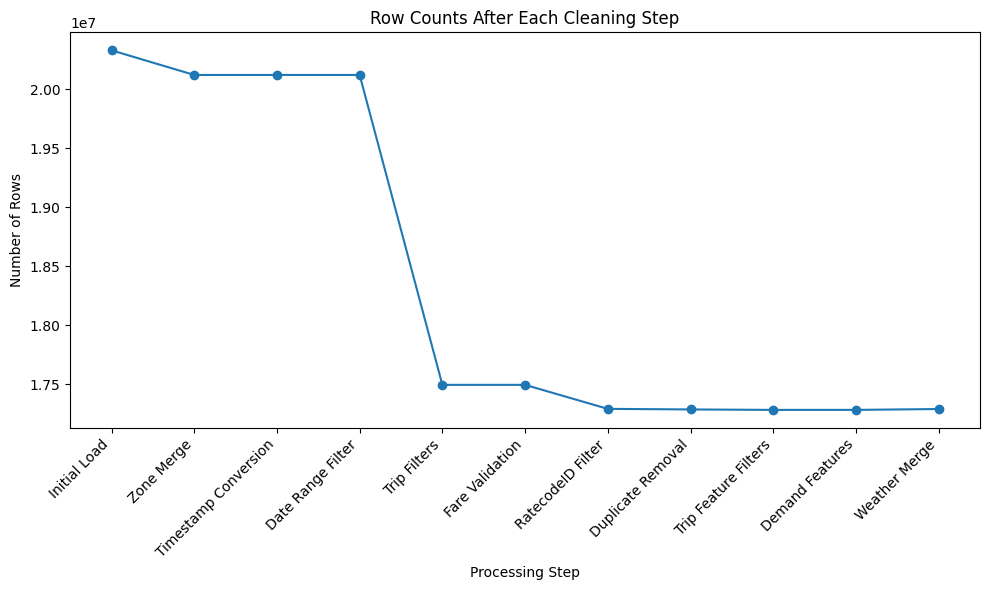

In [7]:
# Plot row counts
counts_df = pd.DataFrame(row_counts)
plt.figure(figsize=(10, 6))
plt.plot(counts_df["step"], counts_df["rows"], marker="o")
plt.title("Row Counts After Each Cleaning Step")
plt.xlabel("Processing Step")
plt.ylabel("Number of Rows")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Step 8: Save Processed Data
Save the cleaned and enriched dataset to CSV.

In [8]:
# Save processed data
taxi_df.to_csv(base_url + "data/processed/cleaned_taxi_data.csv", index=False)
print(f"Saved processed dataset to {base_url}data/processed/cleaned_taxi_data.csv")

Saved processed dataset to /Users/saleh/Desktop/Projects/AIProject/TaxiOptimization/data/processed/cleaned_taxi_data.csv


In [9]:
print(len(taxi_df))

17290240
